Linear regression to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection
from sklearn.decomposition import PCA
from sklearn import metrics, svm, neural_network, ensemble
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190708-091424'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings()

In [3]:
param_dist = { 'alpha': sp.stats.uniform(0, 1) }

In [4]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

predictions = {}
actuals = {}
models = {}
for station in station_data_dict.keys():
    station_data = station_data_dict[station]
    station_train = station_data.loc[train_start : train_end]
    station_test = station_data.loc[test_start : test_end]

    m = linear_model.Ridge(random_state=123)
    m = model_selection.RandomizedSearchCV(m, param_dist, n_iter=100, cv=3, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1, random_state=123, verbose=5)
    m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'])

    cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
    print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
    print('Best params: {}'.format(m.best_params_))
    print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])
    
    station_test = station_test[~pd.isna(station_test['runoff'])]
    if len(station_test) == 0:
        print('Skipping', station)
        continue

    predict = pd.DataFrame(index=station_test.index)
    predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
    predict['runoff'] = np.nan
    predict['runoff'] = m.predict(predict.drop('runoff', axis=1))

    predictions[station] = predict[['runoff']]
    actuals[station] = station_test['runoff']
    models[station] = m

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   13.9s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   19.4s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.7s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -186.748369        -64.643442
87   0.0435915      -189.202015        -65.890072
13   0.0596779      -191.038632        -66.633774
65    0.083195      -193.749922        -67.742113
30   0.0921049      -194.751170        -68.159916
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -64.6434
mean_test_score    -186.748
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.1s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   20.1s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.9s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -110.971653        -54.898091
87   0.0435915      -112.830278        -55.980721
13   0.0596779      -114.046976        -56.602977
65    0.083195      -115.762822        -57.500534
30   0.0921049      -116.378769        -57.830346
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -54.8981
mean_test_score    -110.972
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    5.0s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done 125 out of 300 | elapsed:    9.8s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   14.2s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.9s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -66.809176        -39.629998
87   0.0435915       -68.286611        -40.609327
13   0.0596779       -69.217435        -41.188226
65    0.083195       -70.504262        -42.004016
30   0.0921049       -70.959181        -42.297415
Best params: {'alpha': 0.01612920669501683}
mean_train_score     -39.63
mean_test_score    -66.8092
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.5s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   20.1s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.4s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -46.106874        -13.522317
87   0.0435915       -47.393990        -13.888814
13   0.0596779       -48.191498        -14.101723
65    0.083195       -49.292553        -14.412311
30   0.0921049       -49.683371        -14.527424
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -13.5223
mean_test_score    -46.1069
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   24.8s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   33.5s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   40.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
91    0.995358     -6433.581525       -255.307994
47     0.98556     -6443.754025       -254.434209
6     0.980764     -6448.769690       -254.004745
38     0.94416     -6487.884255       -250.686110
84    0.925132     -6508.819873       -248.931719
Best params: {'alpha': 0.9953584820340174}
mean_train_score   -255.308
mean_test_score    -6433.58
Name: 91, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    4.5s remaining:   16.6s
[Parallel(n_jobs=-1)]: Done 125 out of 300 | elapsed:    8.9s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   12.2s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.2s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -25.545504        -11.514254
87   0.0435915       -27.024404        -12.016323
13   0.0596779       -27.800339        -12.297115
65    0.083195       -28.786698        -12.675939
30   0.0921049       -29.117864        -12.808033
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -11.5143
mean_test_score    -25.5455
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    4.9s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done 125 out of 300 | elapsed:    8.3s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   11.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.4s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -94.378724        -45.532922
87   0.0435915       -97.236493        -46.804874
13   0.0596779       -98.859045        -47.591529
65    0.083195      -101.106784        -48.778596
30   0.0921049      -101.913480        -49.228256
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -45.5329
mean_test_score    -94.3787
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   14.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   19.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.5s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -23.586650         -6.039404
87   0.0435915       -24.183386         -6.230148
13   0.0596779       -24.524121         -6.327328
65    0.083195       -25.000763         -6.467360
30   0.0921049       -25.173157         -6.519551
Best params: {'alpha': 0.01612920669501683}
mean_train_score    -6.0394
mean_test_score    -23.5867
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    5.3s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done 125 out of 300 | elapsed:    9.9s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   14.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.6s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -33.545601        -12.485196
87   0.0435915       -34.606795        -13.017350
13   0.0596779       -35.205432        -13.319408
65    0.083195       -36.025475        -13.750492
30   0.0921049       -36.316232        -13.907634
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -12.4852
mean_test_score    -33.5456
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   13.8s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   18.1s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -68.341302        -30.021154
87   0.0435915       -70.575456        -30.804059
13   0.0596779       -71.877040        -31.304493
65    0.083195       -73.681692        -32.056633
30   0.0921049       -74.328024        -32.339830
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -30.0212
mean_test_score    -68.3413
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   14.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   18.8s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.0s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -104.207793        -34.094359
87   0.0435915      -107.743814        -35.122512
13   0.0596779      -109.610074        -35.681951
65    0.083195      -112.147908        -36.510018
30   0.0921049      -113.051830        -36.822857
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -34.0944
mean_test_score    -104.208
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    4.4s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done 125 out of 300 | elapsed:    8.2s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   11.5s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.2s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -30.075578        -14.596184
87   0.0435915       -31.191550        -15.115930
13   0.0596779       -31.859949        -15.427696
65    0.083195       -32.755246        -15.871743
30   0.0921049       -33.066345        -16.032629
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -14.5962
mean_test_score    -30.0756
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   12.8s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   17.0s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.7s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -20.595314         -9.580570
87   0.0435915       -21.373031        -10.059768
13   0.0596779       -21.832520        -10.382695
65    0.083195       -22.463585        -10.858400
30   0.0921049       -22.687130        -11.033958
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -9.58057
mean_test_score    -20.5953
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   14.4s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   19.4s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.2s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -180.558406        -55.908061
87   0.0435915      -182.918730        -57.610257
13   0.0596779      -184.356093        -58.513228
65    0.083195      -186.410563        -59.838022
30   0.0921049      -187.162777        -60.336800
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -55.9081
mean_test_score    -180.558
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   16.1s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   21.1s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.6s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -575.669039       -132.991875
87   0.0435915      -582.131953       -137.537847
13   0.0596779      -586.238111       -139.609887
65    0.083195      -592.280897       -142.558679
30   0.0921049      -594.547688       -143.667940
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -132.992
mean_test_score    -575.669
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.9s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -60.705816        -30.191119
87   0.0435915       -61.258304        -30.890782
13   0.0596779       -61.612332        -31.286023
65    0.083195       -62.120547        -31.851810
30   0.0921049       -62.305276        -32.058847
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -30.1911
mean_test_score    -60.7058
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    5.1s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.7s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -153.156434        -61.118834
87   0.0435915      -155.830187        -62.642169
13   0.0596779      -157.282138        -63.484079
65    0.083195      -159.335312        -64.735043
30   0.0921049      -160.087741        -65.209255
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -61.1188
mean_test_score    -153.156
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   14.6s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   19.4s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.5s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -40.055097        -17.716858
87   0.0435915       -40.640711        -18.247933
13   0.0596779       -41.010209        -18.580152
65    0.083195       -41.548531        -19.075143
30   0.0921049       -41.746973        -19.260477
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -17.7169
mean_test_score    -40.0551
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.7s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   20.6s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.2s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -357.477537        -86.986185
87   0.0435915      -360.283603        -89.510114
13   0.0596779      -361.762104        -90.364817
65    0.083195      -363.733431        -91.413957
30   0.0921049      -364.426547        -91.776427
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -86.9862
mean_test_score    -357.478
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   13.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   17.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   21.6s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -26.956821        -10.448545
87   0.0435915       -27.739887        -10.825434
13   0.0596779       -28.131231        -10.996055
65    0.083195       -28.626555        -11.222857
30   0.0921049       -28.793316        -11.302570
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -10.4485
mean_test_score    -26.9568
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    4.7s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done 125 out of 300 | elapsed:    8.9s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   13.2s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.2s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -24.235679         -9.852802
87   0.0435915       -24.736251        -10.183580
13   0.0596779       -25.032819        -10.369627
65    0.083195       -25.442071        -10.632641
30   0.0921049       -25.587265        -10.727819
Best params: {'alpha': 0.01612920669501683}
mean_train_score    -9.8528
mean_test_score    -24.2357
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   14.6s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   19.4s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.2s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -25.193274         -7.835347
87   0.0435915       -26.409619         -8.242070
13   0.0596779       -27.047045         -8.474314
65    0.083195       -27.920333         -8.813422
30   0.0921049       -28.232561         -8.939594
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -7.83535
mean_test_score    -25.1933
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   16.6s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   21.6s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.2s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -96.217631        -26.068127
87   0.0435915      -101.999472        -28.135869
13   0.0596779      -105.019031        -29.240757
65    0.083195      -109.204538        -30.843138
30   0.0921049      -110.723184        -31.443543
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -26.0681
mean_test_score    -96.2176
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   16.1s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   21.0s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.6s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -385.382317        -70.196904
87   0.0435915      -400.199916        -75.253903
13   0.0596779      -407.822249        -77.680060
65    0.083195      -418.865257        -81.116088
30   0.0921049      -423.022641        -82.396700
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -70.1969
mean_test_score    -385.382
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.1s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   19.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.0s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292        -7.490284         -2.772198
87   0.0435915        -7.983857         -2.987035
13   0.0596779        -8.221506         -3.089854
65    0.083195        -8.538481         -3.232725
30   0.0921049        -8.650912         -3.285044
Best params: {'alpha': 0.01612920669501683}
mean_train_score    -2.7722
mean_test_score    -7.49028
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.2s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   20.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.5s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -44.206309        -14.706861
87   0.0435915       -47.241103        -16.160424
13   0.0596779       -48.664079        -16.788794
65    0.083195       -50.513258        -17.623771
30   0.0921049       -51.158449        -17.922726
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -14.7069
mean_test_score    -44.2063
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.5s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   20.8s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.2s finished


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -233.731949        -32.757080
87   0.0435915      -242.830797        -34.445101
13   0.0596779      -246.760065        -35.051107
65    0.083195      -251.877954        -35.826899
30   0.0921049      -253.678334        -36.103965
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -32.7571
mean_test_score    -233.732
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   21.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   31.0s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   37.6s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292     -2119.525767       -136.293439
87   0.0435915     -2141.950613       -145.947930
13   0.0596779     -2155.060602       -150.331451
65    0.083195     -2176.541175       -156.492574
30   0.0921049     -2185.220689       -158.785260
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -136.293
mean_test_score    -2119.53
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    4.8s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done 125 out of 300 | elapsed:    8.7s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   12.6s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.7s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -44.808557        -17.768745
87   0.0435915       -47.379303        -18.993857
13   0.0596779       -48.790079        -19.766532
65    0.083195       -50.645057        -20.866569
30   0.0921049       -51.283482        -21.263602
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -17.7687
mean_test_score    -44.8086
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   31.1s remaining:   19.1s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   38.8s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   45.0s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


   param_alpha  mean_test_score  mean_train_score
91    0.995358   -221295.675098        -34.728501
47     0.98556   -221386.127560        -34.095784
6     0.980764   -221430.455370        -33.787936
38     0.94416   -221770.097953        -31.477639
84    0.925132   -221947.559792        -30.304525
Best params: {'alpha': 0.9953584820340174}
mean_train_score   -34.7285
mean_test_score     -221296
Name: 91, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   19.8s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   25.4s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   30.1s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


   param_alpha  mean_test_score  mean_train_score
87   0.0435915     -1868.867232       -371.162685
74   0.0161292     -1869.352318       -356.048212
13   0.0596779     -1872.400071       -379.749848
65    0.083195     -1880.647932       -392.851878
30   0.0921049     -1884.428296       -397.912588
Best params: {'alpha': 0.04359146379904055}
mean_train_score   -371.163
mean_test_score    -1868.87
Name: 87, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.5s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -244.798551       -101.239679
87   0.0435915      -254.502622       -105.795235
13   0.0596779      -259.685210       -108.575424
65    0.083195      -266.668356       -112.678455
30   0.0921049      -269.132206       -114.207474
Best params: {'alpha': 0.01612920669501683}
mean_train_score    -101.24
mean_test_score    -244.799
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    4.7s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done 125 out of 300 | elapsed:    9.1s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   12.2s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.7s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -97.923382        -44.292751
87   0.0435915      -101.672626        -46.566168
13   0.0596779      -104.485594        -48.043238
65    0.083195      -108.676033        -50.212707
30   0.0921049      -110.226989        -51.013620
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -44.2928
mean_test_score    -97.9234
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   22.3s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   28.9s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   34.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292    -10949.380721       -806.966277
87   0.0435915    -11336.909276       -872.353988
13   0.0596779    -11606.983278       -901.576772
65    0.083195    -11992.584811       -940.107094
30   0.0921049    -12131.905135       -953.765919
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -806.966
mean_test_score    -10949.4
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    5.4s remaining:   20.1s
[Parallel(n_jobs=-1)]: Done 125 out of 300 | elapsed:   10.9s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.2s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   21.5s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -821.603185       -309.556889
87   0.0435915      -827.809255       -321.247078
13   0.0596779      -834.593536       -327.366421
65    0.083195      -846.245169       -336.303635
30   0.0921049      -850.940850       -339.669039
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -309.557
mean_test_score    -821.603
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.3s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -410.613851       -187.924324
87   0.0435915      -422.811359       -196.432560
13   0.0596779      -430.505540       -200.958106
65    0.083195      -441.705409       -207.434701
30   0.0921049      -445.843042       -209.826803
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -187.924
mean_test_score    -410.614
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.8s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   20.3s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.4s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -956.111856       -302.368951
87   0.0435915      -986.973149       -316.274277
13   0.0596779     -1005.653404       -324.059914
65    0.083195     -1032.287671       -335.500963
30   0.0921049     -1042.008743       -339.798269
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -302.369
mean_test_score    -956.112
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   11.6s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   15.7s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.8s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -22.882309        -11.774785
87   0.0435915       -24.512933        -12.718420
13   0.0596779       -25.628213        -13.319034
65    0.083195       -27.213298        -14.174889
30   0.0921049       -27.781403        -14.483978
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -11.7748
mean_test_score    -22.8823
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   20.4s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   26.6s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   31.6s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292     -2162.611006       -231.033749
87   0.0435915     -2196.703811       -250.580428
13   0.0596779     -2223.431252       -258.632044
65    0.083195     -2267.306639       -269.342056
30   0.0921049     -2284.867106       -273.225348
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -231.034
mean_test_score    -2162.61
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.2s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   20.1s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.0s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -383.526550       -163.147663
87   0.0435915      -391.407574       -172.121195
13   0.0596779      -399.535597       -176.934265
65    0.083195      -413.008298       -183.963327
30   0.0921049      -418.314064       -186.599474
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -163.148
mean_test_score    -383.527
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    5.5s remaining:   20.4s
[Parallel(n_jobs=-1)]: Done 125 out of 300 | elapsed:   11.4s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.3s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292     -2187.757557       -369.337261
87   0.0435915     -2215.947063       -387.316396
13   0.0596779     -2253.053088       -396.579325
65    0.083195     -2317.348792       -410.209176
30   0.0921049     -2343.238232       -415.390786
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -369.337
mean_test_score    -2187.76
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.7s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   20.8s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.8s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
87   0.0435915      -168.269495        -81.606349
74   0.0161292      -168.667448        -79.376879
13   0.0596779      -168.998183        -82.917271
65    0.083195      -170.658281        -84.889352
30   0.0921049      -171.395616        -85.639105
Best params: {'alpha': 0.04359146379904055}
mean_train_score   -81.6063
mean_test_score    -168.269
Name: 87, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   15.9s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   21.5s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.2s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
87   0.0435915      -750.419558       -248.191533
74   0.0161292      -750.702762       -242.138884
13   0.0596779      -755.447261       -251.112476
65    0.083195      -765.271474       -255.283853
30   0.0921049      -769.380411       -256.838480
Best params: {'alpha': 0.04359146379904055}
mean_train_score   -248.192
mean_test_score     -750.42
Name: 87, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  64 out of 300 | elapsed:    2.2s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done 125 out of 300 | elapsed:    4.4s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:    6.5s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
91    0.995358      -294.989757         -1.696696
47     0.98556      -295.376417         -1.671375
6     0.980764      -295.566584         -1.659011
38     0.94416      -297.038626         -1.565298
84    0.925132      -297.818454         -1.517060
Best params: {'alpha': 0.9953584820340174}
mean_train_score   -1.6967
mean_test_score    -294.99
Name: 91, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   11.7s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   15.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.7s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.


   param_alpha  mean_test_score  mean_train_score
74   0.0161292       -66.431867        -36.893574
87   0.0435915       -68.137117        -38.060849
13   0.0596779       -69.237669        -38.765130
65    0.083195       -70.777667        -39.747658
30   0.0921049       -71.324933        -40.097577
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -36.8936
mean_test_score    -66.4319
Name: 74, dtype: object
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 186 out of 300 | elapsed:   13.2s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done 247 out of 300 | elapsed:   17.5s remaining:    3.8s


   param_alpha  mean_test_score  mean_train_score
74   0.0161292      -129.760868        -64.278600
87   0.0435915      -132.999642        -66.065200
13   0.0596779      -135.096776        -67.168231
65    0.083195      -138.055703        -68.748162
30   0.0921049      -139.115618        -69.321788
Best params: {'alpha': 0.01612920669501683}
mean_train_score   -64.2786
mean_test_score    -129.761
Name: 74, dtype: object


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   21.2s finished


/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


02GA010 	NSE: 0.23834726616365864 	MSE: 363.13587645989753 (clipped to 0)
02GA018 	NSE: 0.2991221286813056 	MSE: 176.0277065251881 (clipped to 0)
02GA038 	NSE: 0.25800808530314623 	MSE: 122.0862046979798 (clipped to 0)
02GA047 	NSE: 0.17018709996328885 	MSE: 65.0490537009281 (clipped to 0)
02GB001 	NSE: -0.03584782742254422 	MSE: 7779.087908686843 (clipped to 0)
02GB007 	NSE: 0.3565781989092085 	MSE: 20.12109591180785 (clipped to 0)
02GC002 	NSE: 0.3982029579344972 	MSE: 77.33274613105372 (clipped to 0)
02GC007 	NSE: 0.30706395220726945 	MSE: 20.87216539388604 (clipped to 0)
02GC010 	NSE: 0.42253100017726797 	MSE: 34.33048572579392 (clipped to 0)
02GC018 	NSE: 0.43297890359618774 	MSE: 38.402525369524255 (clipped to 0)
02GC026 	NSE: 0.4287920418568525 	MSE: 91.86894863879589 (clipped to 0)
02GD004 	NSE: 0.37898539787058827 	MSE: 34.19497262757824 (clipped to 0)
02GE007 	NSE: 0.48767508314045516 	MSE: 18.533383827964848 (clipped to 0)
02GG002 	NSE: 0.44216896474427303 	MSE: 134.53926575

../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: Ru

04174500 	NSE: 0.005949716083197609 	MSE: 94.01154672933144 (clipped to 0)
04176500 	NSE: -0.05874215258639781 	MSE: 723.1994662191821 (clipped to 0)
04177000 	NSE: 0.36844349791893494 	MSE: 17.02034024714498 (clipped to 0)
04193500 	NSE: -0.9654778780370068 	MSE: 139157.30643437852 (clipped to 0)
04195820 	NSE: 0.2581432007900747 	MSE: 870.7873084923882 (clipped to 0)
04196800 	NSE: 0.5365506022863178 	MSE: 138.6865310566974 (clipped to 0)
04197100 	NSE: 0.5845953217295347 	MSE: 42.60573563143687 (clipped to 0)
04198000 	NSE: 0.3394808442834747 	MSE: 4879.624498971593 (clipped to 0)
04199000 	NSE: 0.4679946484453392 	MSE: 544.0304280035197 (clipped to 0)


../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: Ru

04199500 	NSE: 0.3808310862187394 	MSE: 250.54553813767666 (clipped to 0)
04200500 	NSE: 0.5131212499194346 	MSE: 487.22197813178326 (clipped to 0)
04207200 	NSE: 0.5667428918913506 	MSE: 10.140942077903345 (clipped to 0)
04208504 	NSE: 0.40252191846590124 	MSE: 583.4544680534127 (clipped to 0)
04209000 	NSE: 0.4903317002678792 	MSE: 159.35086007522082 (clipped to 0)
04212100 	NSE: 0.38129754295605445 	MSE: 908.456308332161 (clipped to 0)
04213000 	NSE: 0.3528446954534551 	MSE: 116.14446832825942 (clipped to 0)
04213500 	NSE: 0.2463334442700974 	MSE: 772.068714009485 (clipped to 0)
04214500 	NSE: -1.6766047081809439 	MSE: 322.630134721872 (clipped to 0)


../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: Ru

04215000 	NSE: 0.3427264422706303 	MSE: 63.13297401199066 (clipped to 0)
04215500 	NSE: 0.2861571182912085 	MSE: 128.90925365165887 (clipped to 0)
Median NSE (clipped to 0) 0.37990824204466384 / Min -1.6766047081809439 / Max 0.5845953217295347
Median MSE (clipped to 0) 109.11964356213701 / Min 3.773554642212663 / Max 139157.30643437852


../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


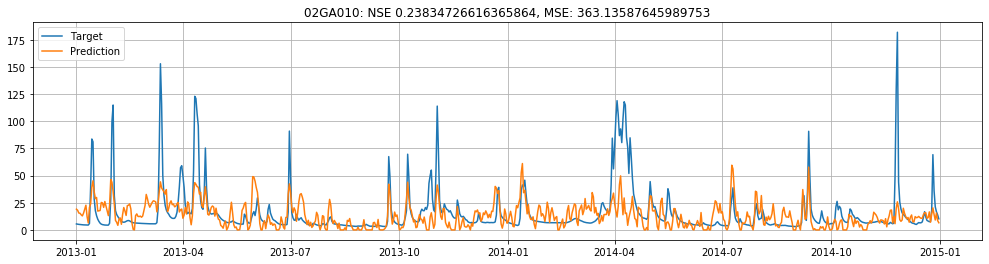

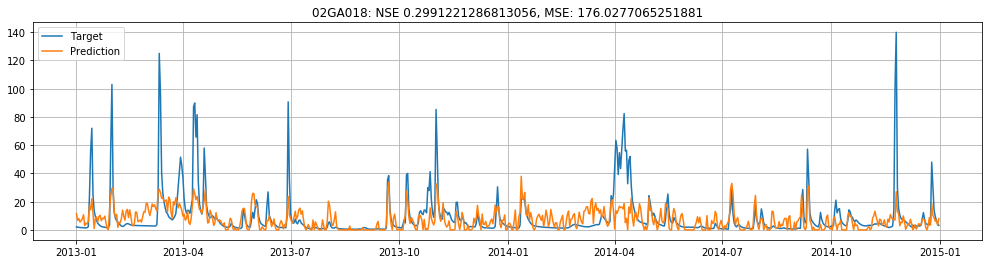

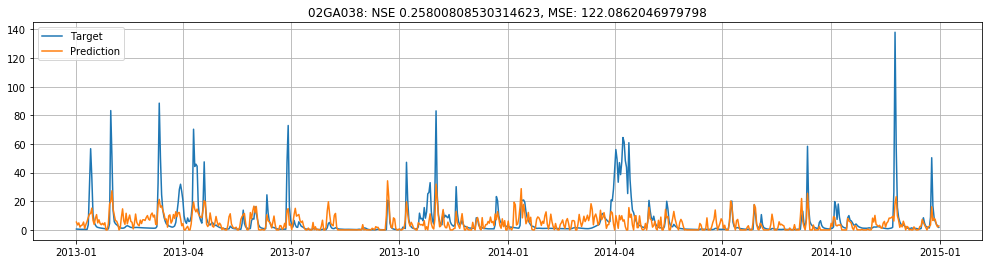

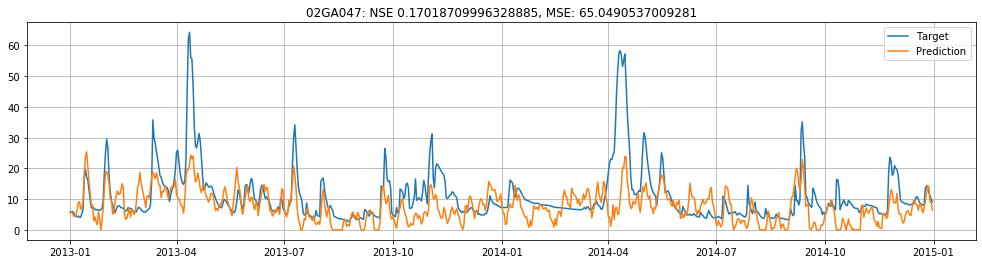

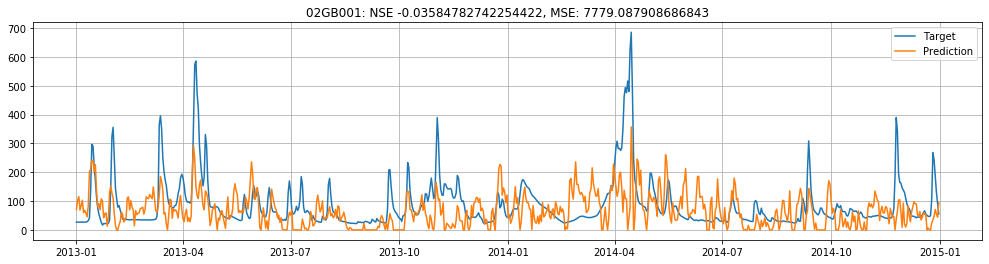

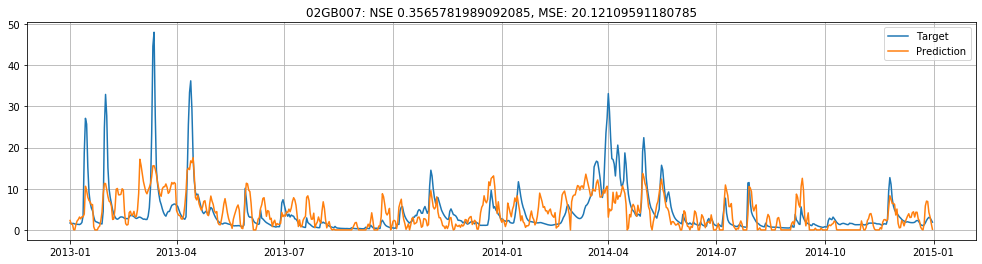

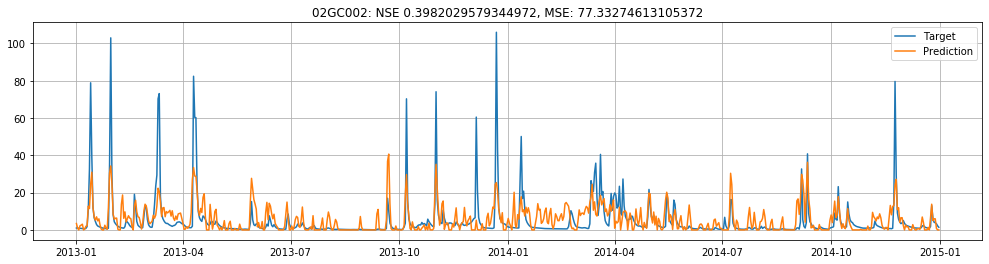

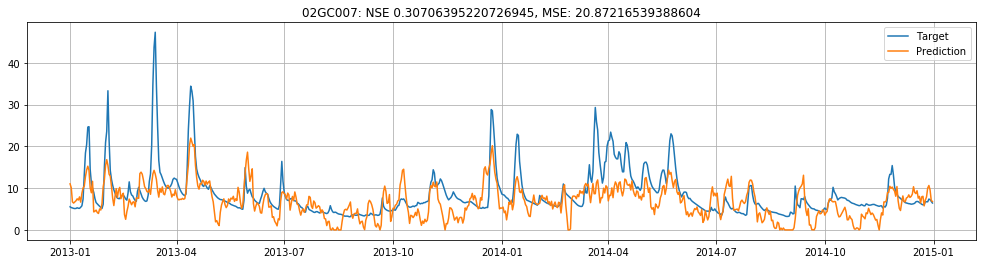

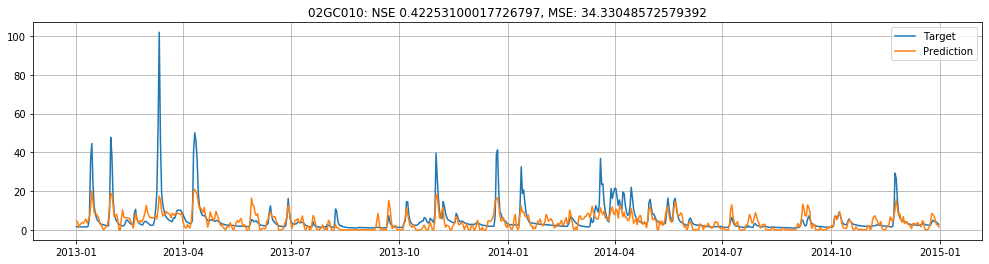

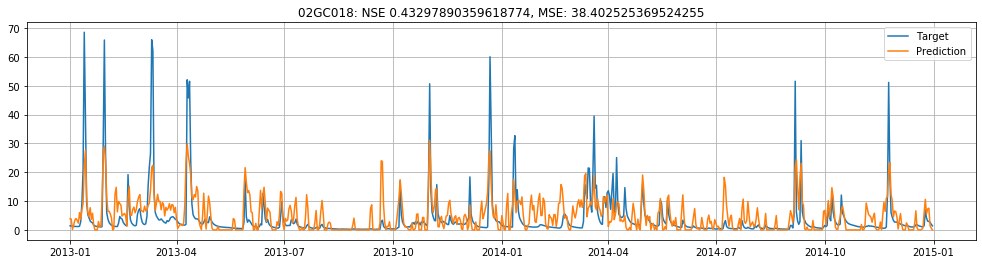

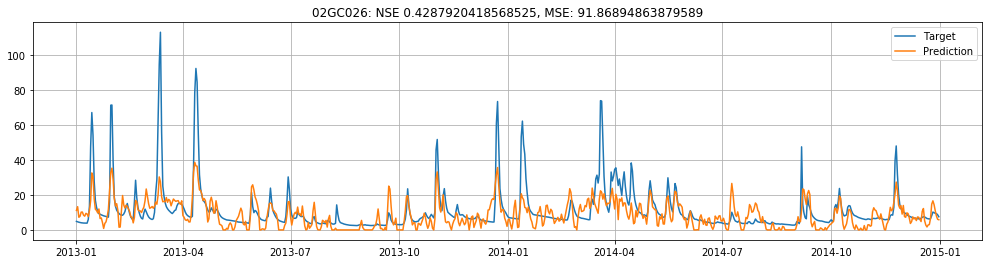

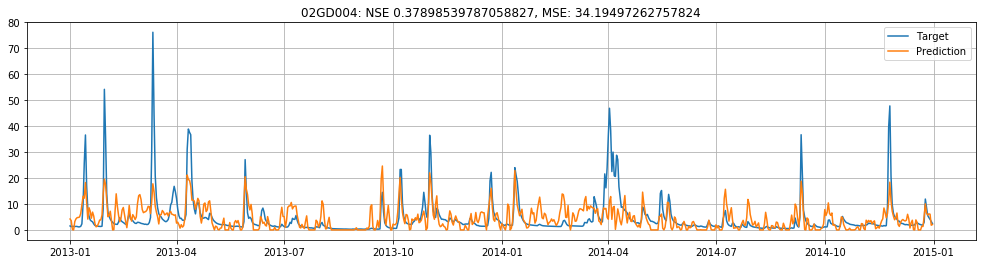

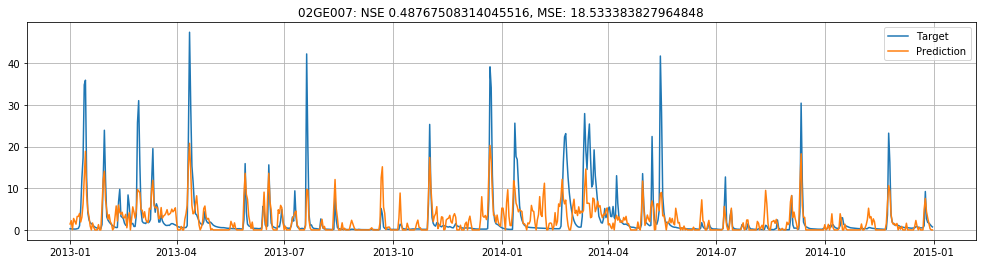

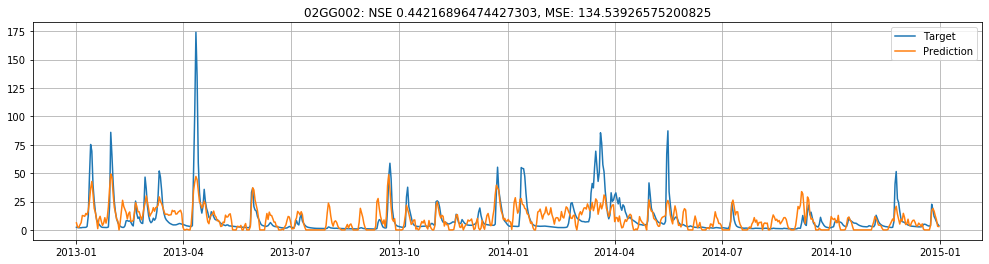

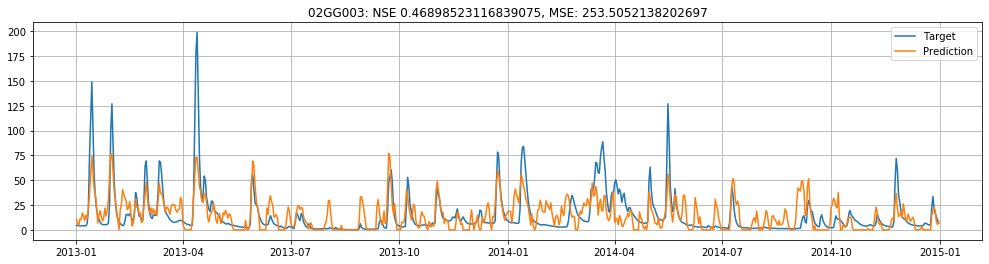

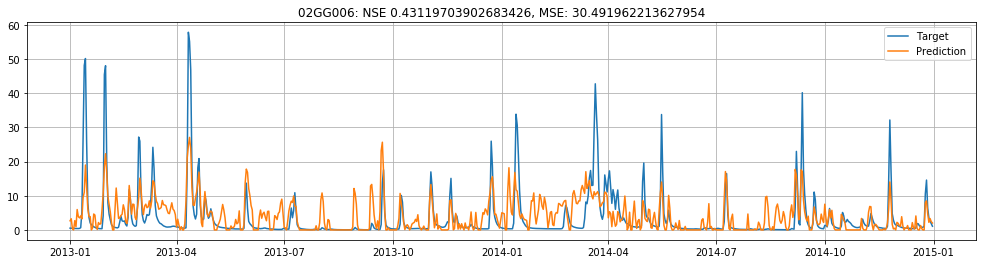

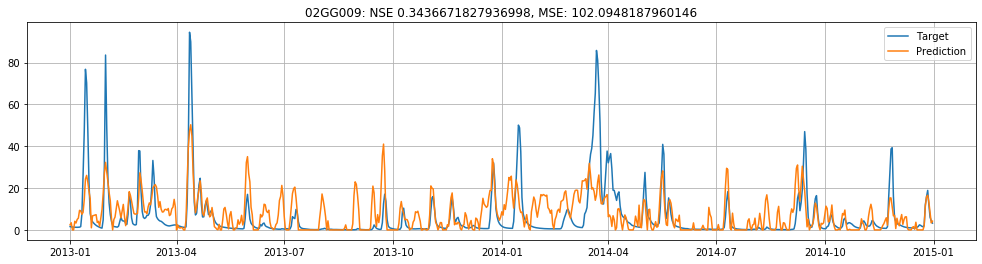

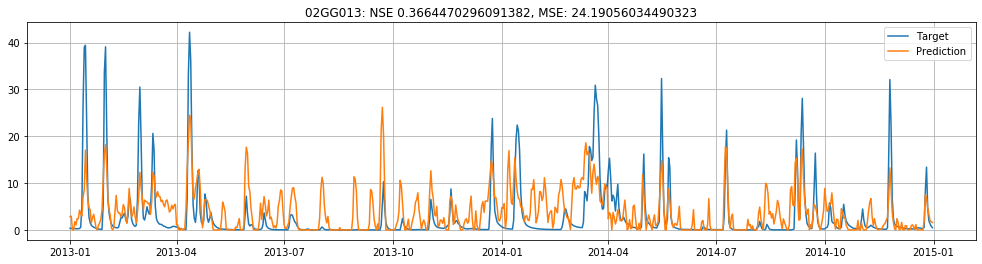

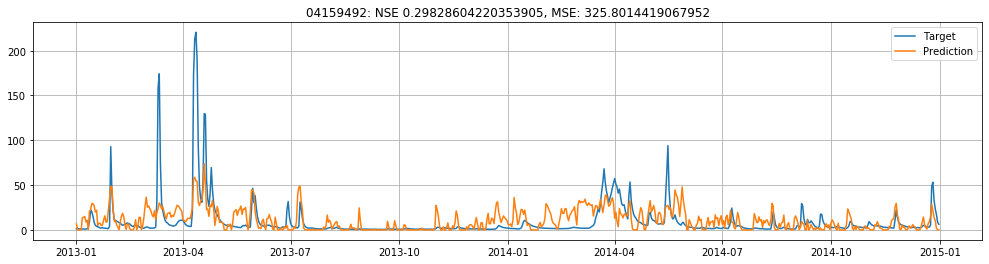

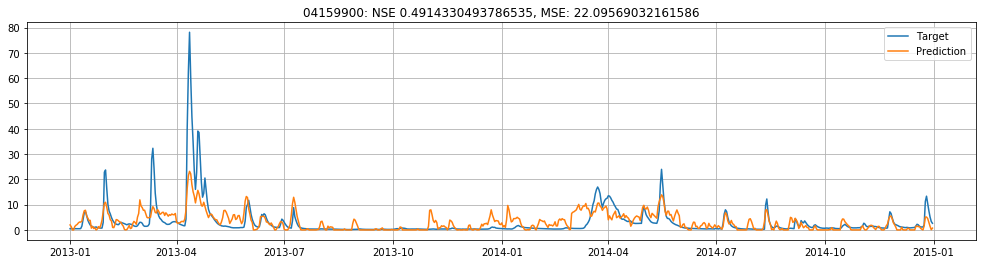

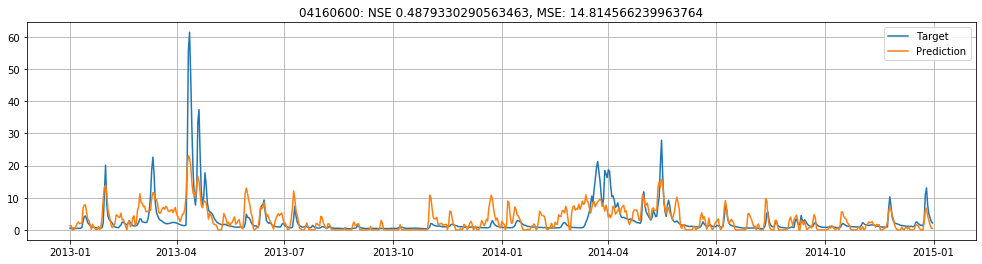

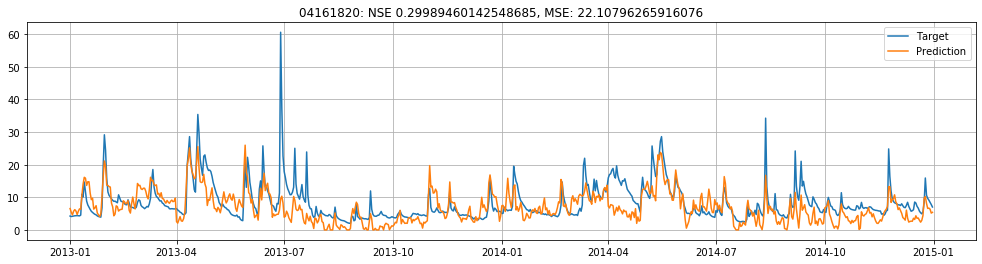

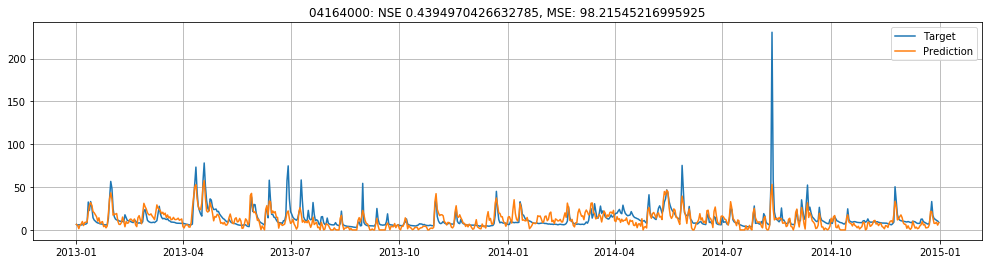

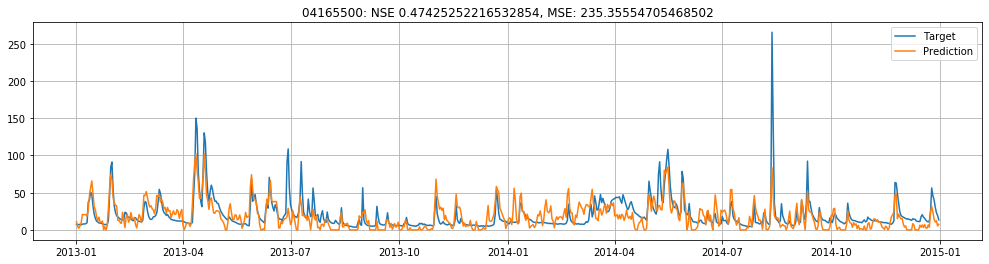

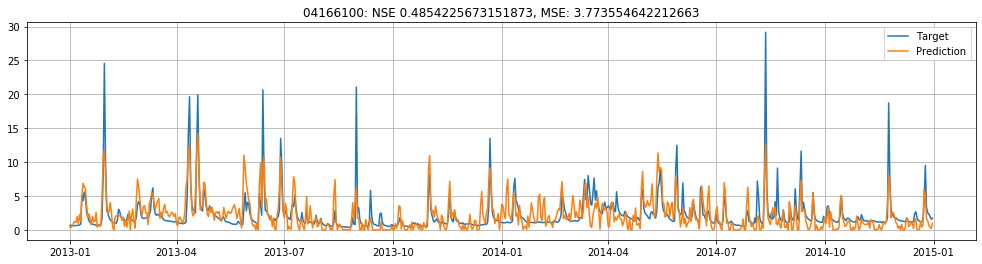

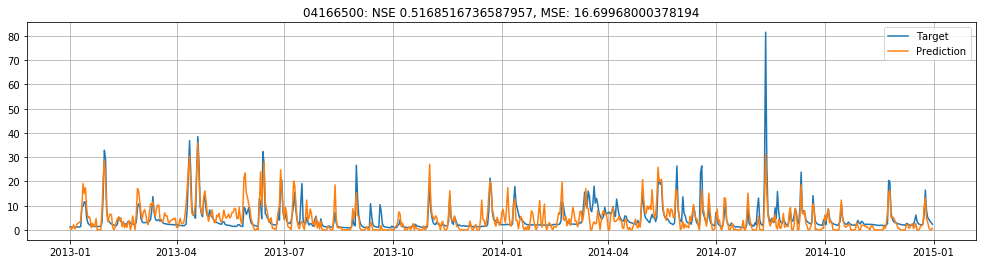

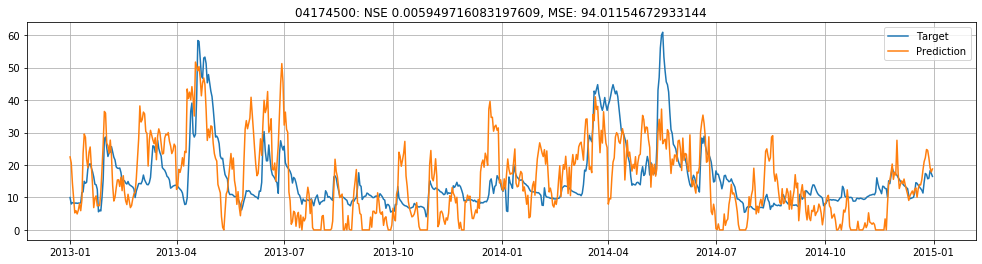

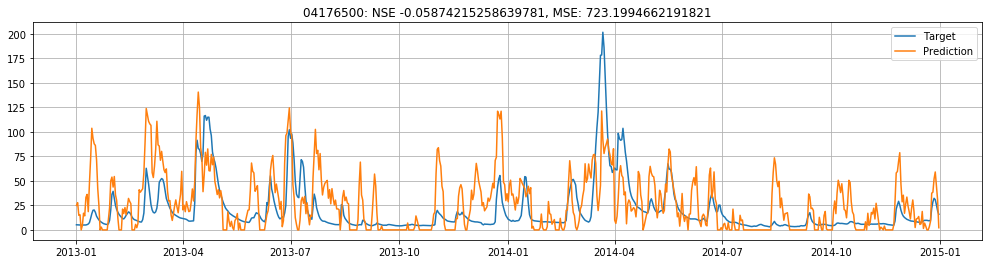

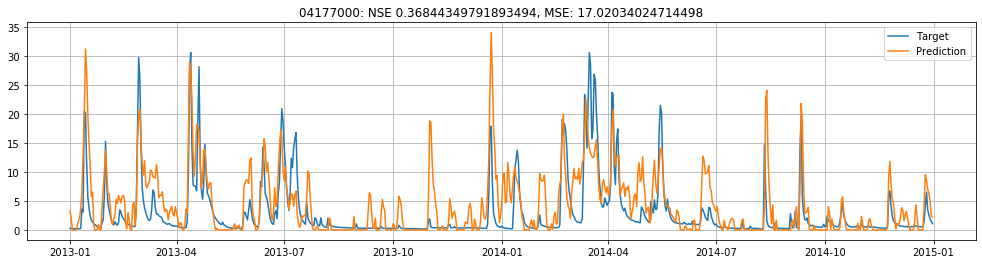

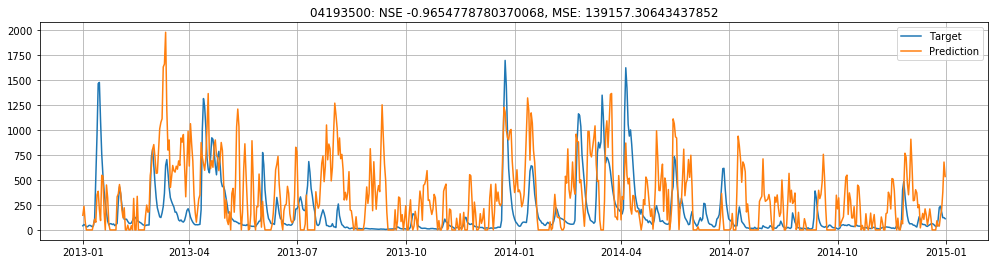

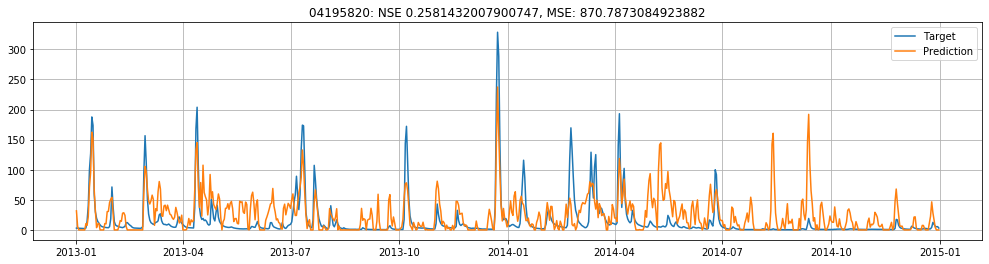

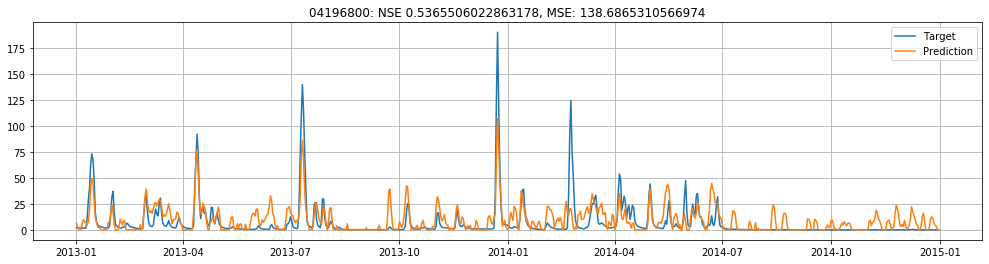

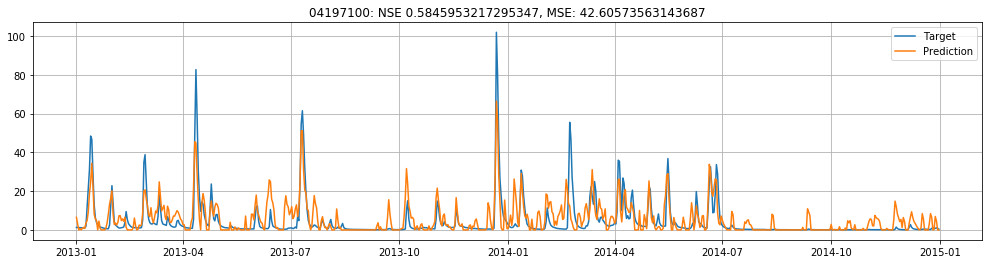

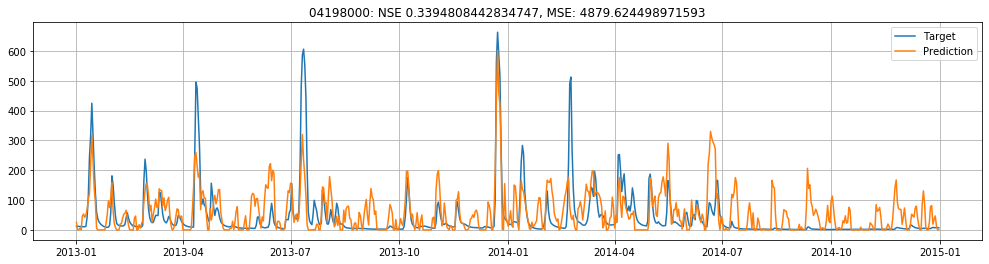

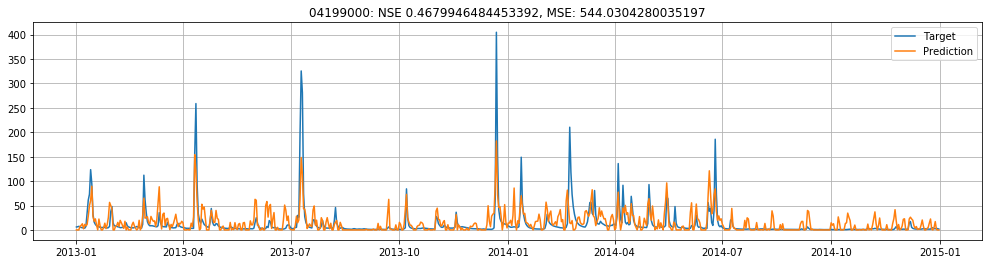

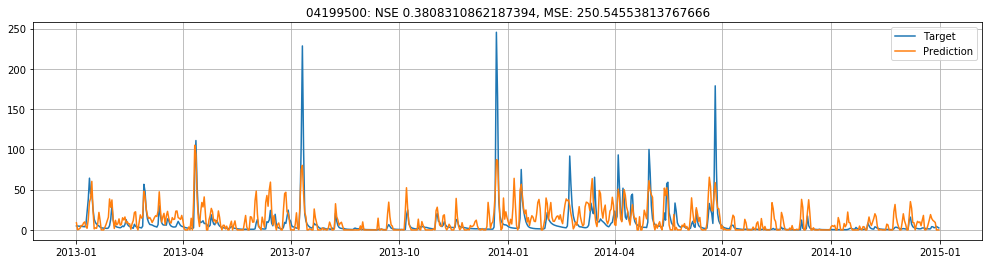

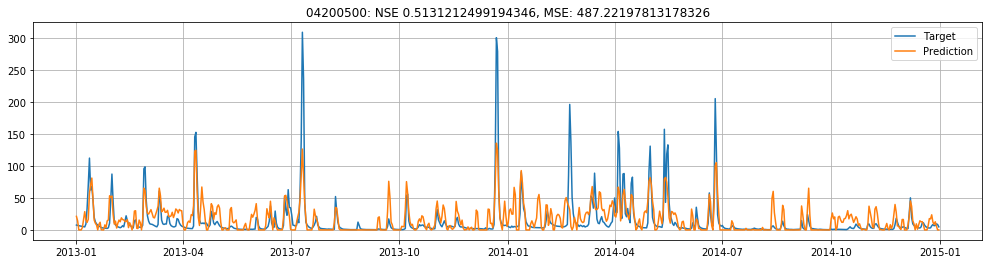

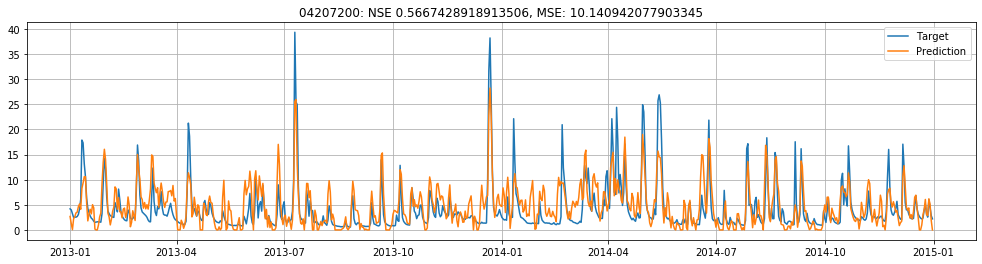

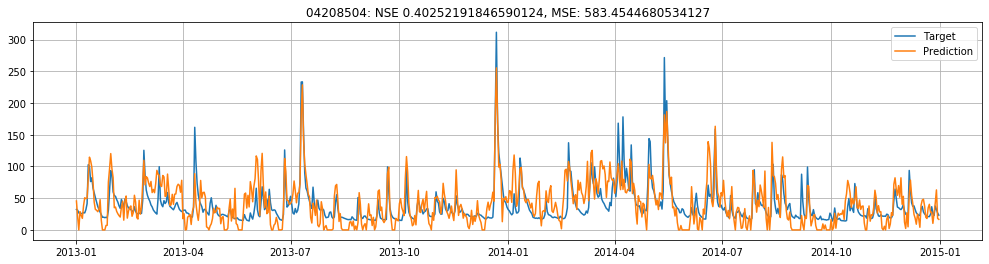

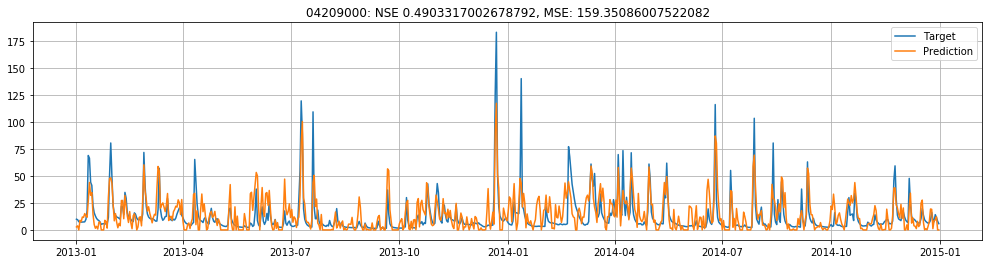

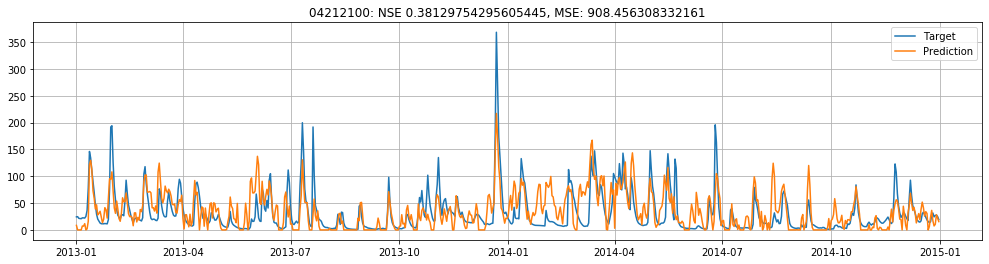

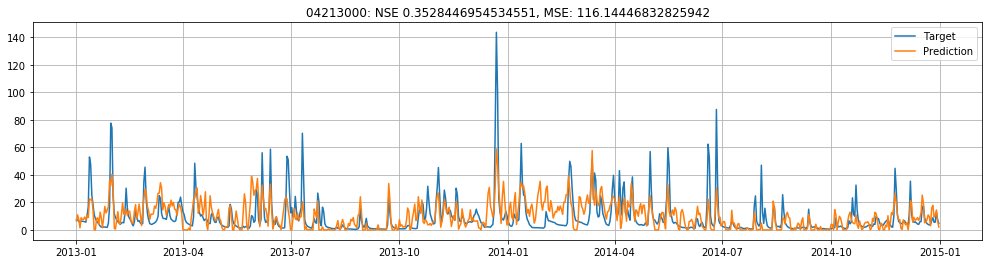

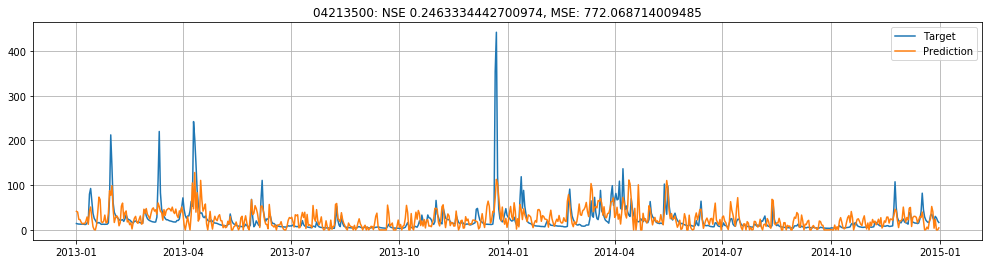

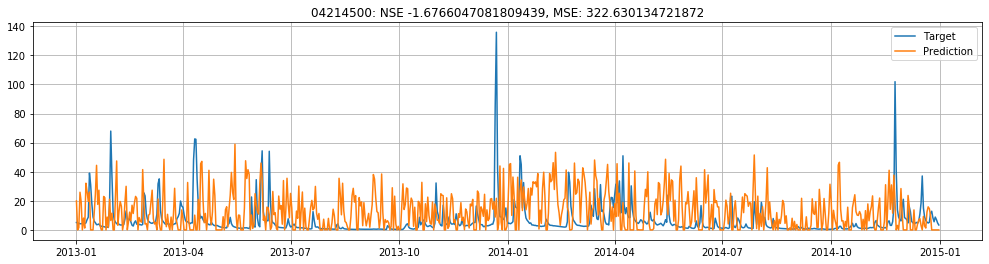

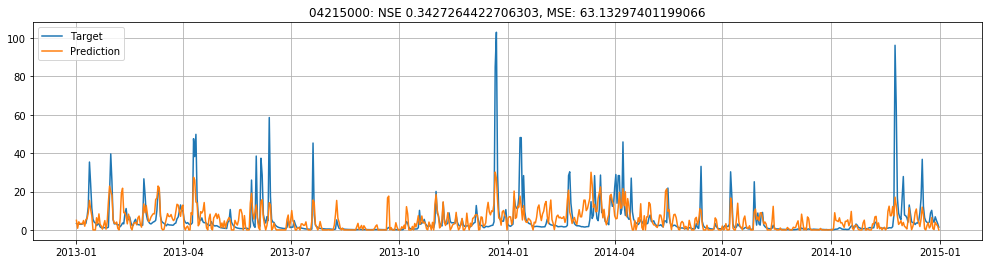

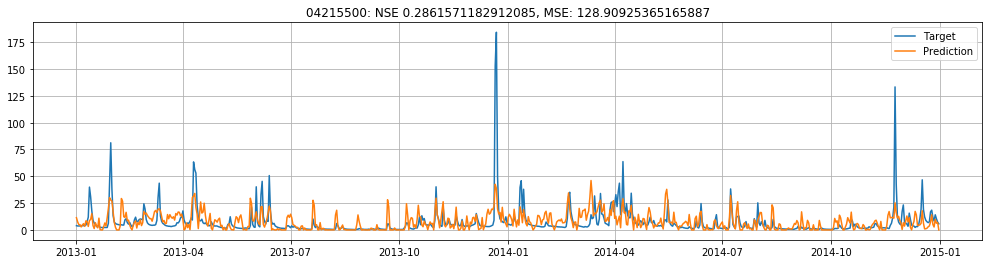

In [5]:
nse_list = []
mse_list = []
for station, predict in predictions.items():
    nse, mse = evaluate.evaluate_daily(station, predict, actuals[station], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [6]:
load_data.pickle_results('LinReg_VIC_aggregateForcings', (predictions, actuals), time_stamp)

'LinReg_VIC_aggregateForcings_20190708-091424.pkl'

In [7]:
for station, model in models.items():
    load_data.pickle_model('LinReg_VIC_aggregateForcings', model, station, time_stamp, model_type='sklearn')

Saved model as ../pickle/models/LinReg_VIC_aggregateForcings_02GA010_20190708-091424.pkl
Saved model as ../pickle/models/LinReg_VIC_aggregateForcings_02GA018_20190708-091424.pkl
Saved model as ../pickle/models/LinReg_VIC_aggregateForcings_02GA038_20190708-091424.pkl
Saved model as ../pickle/models/LinReg_VIC_aggregateForcings_02GA047_20190708-091424.pkl
Saved model as ../pickle/models/LinReg_VIC_aggregateForcings_02GB001_20190708-091424.pkl
Saved model as ../pickle/models/LinReg_VIC_aggregateForcings_02GB007_20190708-091424.pkl
Saved model as ../pickle/models/LinReg_VIC_aggregateForcings_02GC002_20190708-091424.pkl
Saved model as ../pickle/models/LinReg_VIC_aggregateForcings_02GC007_20190708-091424.pkl
Saved model as ../pickle/models/LinReg_VIC_aggregateForcings_02GC010_20190708-091424.pkl
Saved model as ../pickle/models/LinReg_VIC_aggregateForcings_02GC018_20190708-091424.pkl
Saved model as ../pickle/models/LinReg_VIC_aggregateForcings_02GC026_20190708-091424.pkl
Saved model as ../pic